<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**News Crawler**

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import html

class News:
  def __init__(self):
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_ranking(self, page=1, date='1'):
    date = str(datetime.datetime.now().date().strftime("%Y%m%d")) if date == '1' else date
    pages = list(range(1,page+1))
    li = []
    for page in pages:
      url = 'https://finance.naver.com/news/news_list.nhn?mode=RANK&date=' + date + '&page=' + str(page)
      result = requests.get(url, headers = self.headers)
      bs_obj = BeautifulSoup(result.content, "html.parser")

      div = bs_obj.find_all('div', {'class':'hotNewsList'})
      li+=[html.unescape(x['href']) for x in div[0].find_all('a')]
    return li

  def get_main(self, date='1'):
    date = str(datetime.datetime.now().date().strftime("%Y-%m-%d")) if date == '1' else date
    url = 'https://finance.naver.com/news/mainnews.nhn'
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    return [x.find_all('a')[0]['href'] for x in bs_obj.find_all('dd', {'class':'articleSubject'})]

  # 시황 전망: 401
  # 기업 종목분석: 402
  # 해외 증시: 403
  # 채권 선물: 404
  # 공시 메모: 406
  # 환율: 429
  def get_focus(self, page=1, code=402, date='1', ):
    date = str(datetime.datetime.now().date().strftime("%Y%m%d")) if date == '1' else date
    pages = range(0,page)
    li = []
    for page in pages:
      url = 'https://finance.naver.com/news/news_list.nhn?mode=LSS3D&section_id=101&section_id2=258&section_id3='\
      + str(code) +  '&date=' + str(date) + '&page=' + str(page)
      result = requests.get(url, headers = self.headers)
      bs_obj = BeautifulSoup(result.content, "html.parser")
      temp = [html.unescape(x.find_all('a')[0]['href']) for x in bs_obj.find_all('dd', {'class':'articleSubject'})]
      # 업데이트 가능
      li+=[x.replace('§', '&sect') for x in temp]
    return li

  def get_article(self, url):
    url = 'https://finance.naver.com/' + url
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    title = ' '.join(bs_obj.find_all('div', {'class': 'article_info'})[0].find_all('h3')[0].get_text().split())
    context = bs_obj.find_all('div', {'class': 'articleCont'})[0]
    try:
      subheading = context.find_all('strong')[0].get_text()
    except:
      subheading = ''
    t = ' '.join(context.get_text().split())
    text = t[:t.find('@')]
    text = text.replace(subheading, '')
    return title, subheading, text

In [3]:
from multiprocessing import Pool

news = News()
news_list = news.get_ranking(5)
with Pool() as p:
    li = p.map(news.get_article, news_list)
li = np.array(li)

dic = {'Title':li[:,0], 'Subheading':li[:,1], 'Text':li[:,2]}
df = pd.DataFrame.from_dict(dic)
df

,Title,Subheading,Text
0,"[특징주]""한국형 스마트시티 수출""…옴니시스템, 약세장서 '나홀로 상승'",,미국 경기침체 우려로 인해 국내 증시가 약세를 이어가고 있는 가운데 옴니시스템이 5...
1,"[특징주] 에이치시티, 국내 최초 파티클 농도 측정 입자 개발 소식에 강세",,[헤럴드경제=양대근 기자] 시험인증·교정산업 전문기업 에이치시티가 클린룸 공기 중 ...
2,"[특징주]티앤알바이오팹, 심장질환 세포치료제 개발 순항…심장 조직 재생 및 회복 확인",,티앤알바이오팹이 강세다. 30일 오전 10시41분 티앤알바이오팹은 전날보다 6.83...
3,"[특징주] 희림, '네옴시티 수주전' 수혜주 부각에 연일 강세",,희림이 네옴시티 수주전에 따른 수혜 기대감으로 연일 강세를 보이고 있다. 희림은 카...
4,"[특징주] 대웅제약, 난청 치료 줄기세포 위탁개발생산 계약… 6%↑",,대웅제약이 난청 치료 줄기세포 위탁개발생산 계약을 체결했다는 소식에 상승세다. 30...
...,...,...,...
118,[뉴욕증시]다우↑S&P500·나스닥↓,,[파이낸셜뉴스] 미국 뉴욕증시가 29일(현지시간) 지수별 혼조세 마감이다. 다우 지...
119,내달 LG에너지솔루션 등 40개사 의무보유 물량 풀린다,,최근 1년간 월별 의무보유등록 해제 현황. 자료=예탁결제원한국예탁결제원은 LG에너지...
120,"한국공인회계사회, 2022년 K-IFRS서 발간",,[한국공인회계사회 제공][헤럴드경제=김성미 기자] 한국공인회계사회는 ‘2022년 한...
121,"주식 떨어졌는데 채권도 불안…""7월 약세장 이어진다""","한국투자증권 보고서①내일부터 오르는 전기·가스요금②공격적 금리인상에 투자심리 꽁꽁""...",[이데일리 김보겸 기자] 국내 증시가 재차 바닥을 깨고 금리가 점차 높아지는 상황에...


In [4]:
# korean font
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip'
!unzip "NotoSansCJKkr-hinted.zip"
!mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/

--2022-06-30 05:55:18--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 172.217.193.128, 2607:f8b0:400c:c03::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip.2’

NotoSansCJKkr-hinte 100%[===================>] 115.55M   193MB/s    in 0.6s    

2022-06-30 05:55:19 (193 MB/s) - ‘NotoSansCJKkr-hinted.zip.2’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
replace LICENSE_OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: LICENSE_OFL.txt         
replace NotoSansCJKkr-Black.otf? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: NotoSansCJKkr-Black.otf  
replace NotoSansCJKkr-Bold.otf? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Not

In [5]:
# https://wikidocs.net/22530
from konlpy.tag import Hannanum
from wordcloud import WordCloud
import matplotlib.pyplot as plt

class Analyser:
  def __init__(self, df):
    self.df = df

  def get_tokenized(self, text):
    hannanum = Hannanum()
    return hannanum.morphs(text) 

  def get_cleaned(self, text):
    text = ([x for x in text if len(x) > 1])
    d = {i:text.count(i) for i in set(text) if text.count(i) > 1}
    words = ' '.join(d.keys())
    return words

  def get_wordcloud(self, column):
    t = analyser.df[column]
    words = self.get_tokenized(' '.join(t))
    words = self.get_cleaned(words)
    words = words.split()
    words = ' '.join(words)
    stop_words = ['있다', '기자', '다만', '등의', '것으로', '기대감', '기대감에', '특징주', '실적', '기대', '최대', '신영', '순매수', '상위종목', '마감', \
                  '코스닥', '규모', '기관', '외국인', '신영증권', '이데일리', '연합뉴스', '서울경제', '하이투자증권', 'NH투자증권', '뉴스1', '영상', '서울', \
                  '뉴시스']
    wordcloud = WordCloud(stopwords = stop_words, \
                          font_path='/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf', \
                          background_color='white', \
                          width=1200, height=800).generate(words)
    plt.figure(figsize=(18,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [6]:
analyser = Analyser(df)

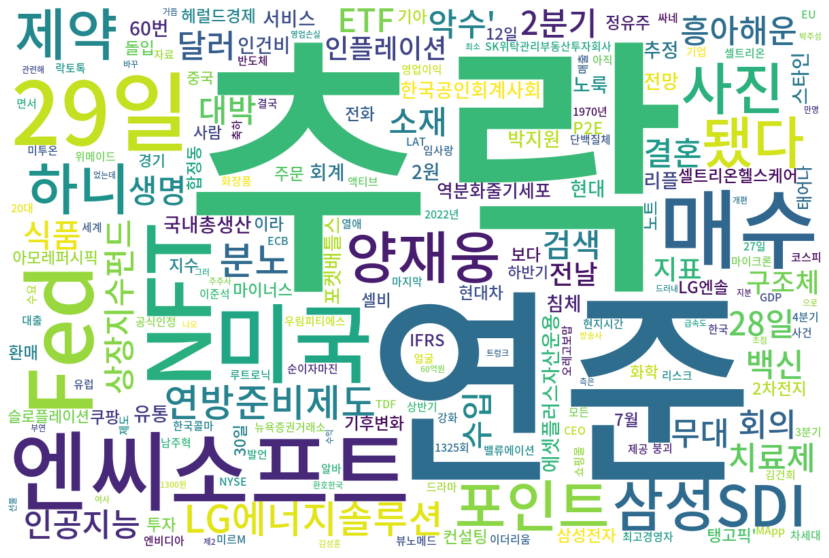

In [7]:
analyser.get_wordcloud('Text')